In [1]:
import tqdm
import torch
import numpy as np
import pandas as pd
from torch import nn, einsum
import seaborn as sns
import scipy.io as sio
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from einops import rearrange, repeat
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# !nvidia-smi
print(torch.cuda.is_available())
print(torch.cuda.current_device())

C:\ProgramData\Anaconda3\envs\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
0


# Big Data

In [4]:
sz_data = np.load("sz_big.npy")
pre_data = np.load("omen_big_30.npy")
nm_data = np.load("norm_big.npy")
print(sz_data.shape, pre_data.shape, nm_data.shape)

(22, 2217984) (22, 9753600) (22, 921600)


In [5]:
data = np.concatenate([sz_data, pre_data, nm_data], 1) # (22, 40701, 256)
data = rearrange(data, 'chn (time hz) -> time hz chn', chn=22, hz=256)
print(data.shape)

lab0 = np.full((8664, 1), 0)
lab1 = np.full((38100, 1), 1)
lab2 = np.full((3600, 1), 2)
label = np.concatenate([lab0, lab1, lab2], 0)
print(label.shape)

(50364, 256, 22)
(50364, 1)


In [6]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data,label ,transform = None):
        self.transform = transform

        self.data = data
        self.label = label

        self.datanum = len(data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data = torch.tensor(self.data[idx]).float()
        out_label = torch.tensor(self.label[idx], dtype=torch.int64)
        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label
    
train, test, train_label, test_label = train_test_split(data, np.array(label),test_size = 0.1,stratify = label, random_state = 0)
print('train data:',len(train))
print('test data:',len(test))

train_data_set = Mydatasets(data=train,label=train_label)
test_data_set = Mydatasets(data=test,label=test_label)

train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 64, shuffle=True)

print(data.shape)

train data: 45327
test data: 5037
(50364, 256, 22)


# RNN encoder

In [11]:
class IndivGRU(nn.Module):
    def __init__(self,gru_input_dim,hidden_dim,n_layer,group):
        super().__init__()
        self.group = group # number of basestations
        self.n_layer = n_layer
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(gru_input_dim,hidden_dim,n_layer,batch_first = True) 
        self.encs = nn.ModuleList(self.gru for i in range(group)) # individual RNN encoder
    
    def forward(self,x):
        # x = rearrange(x,'batch band freq time -> band batch time freq')
        # 每个通道走一个GRU
        x = rearrange(x, 'batch time (chnl dim) -> chnl batch time dim', time=256, chnl=22, dim=1)
        lstm_out = []
        for t in range(self.group): # group=chnl
            enc = self.encs[t]
            r_out,_ = enc(x[t],None)
            
            lstm_out.append(r_out)
        # lstm_out = rearrange(lstm_out,'band batch time freq -> batch time (band freq)')
        lstm_out = rearrange(lstm_out,'chnl batch time dim -> batch time (chnl dim)', time=256, chnl=22, dim=1)
        return lstm_out

In [10]:
# d = torch.rand([16,2,20,30]) # batch,channel,freq,time
# d = torch.reshape(d,(16,2,5,4,30))
# x_seq = rearrange(d,'batch channel band freq time -> batch band freq (channel time)  ')
# #x_seq = x_seq[:,:,[16,-1],:]
# print(x_seq.shape)

In [12]:
dd = torch.rand([400, 256, 22])
mm = IndivGRU(gru_input_dim=1, hidden_dim=1, n_layer=2, group=22)
print(mm)
mmout = mm(dd)
print(mmout.shape) # expect snn output dim -> batch,300,4

IndivGRU(
  (gru): GRU(1, 1, num_layers=2, batch_first=True)
  (encs): ModuleList(
    (0): GRU(1, 1, num_layers=2, batch_first=True)
    (1): GRU(1, 1, num_layers=2, batch_first=True)
    (2): GRU(1, 1, num_layers=2, batch_first=True)
    (3): GRU(1, 1, num_layers=2, batch_first=True)
    (4): GRU(1, 1, num_layers=2, batch_first=True)
    (5): GRU(1, 1, num_layers=2, batch_first=True)
    (6): GRU(1, 1, num_layers=2, batch_first=True)
    (7): GRU(1, 1, num_layers=2, batch_first=True)
    (8): GRU(1, 1, num_layers=2, batch_first=True)
    (9): GRU(1, 1, num_layers=2, batch_first=True)
    (10): GRU(1, 1, num_layers=2, batch_first=True)
    (11): GRU(1, 1, num_layers=2, batch_first=True)
    (12): GRU(1, 1, num_layers=2, batch_first=True)
    (13): GRU(1, 1, num_layers=2, batch_first=True)
    (14): GRU(1, 1, num_layers=2, batch_first=True)
    (15): GRU(1, 1, num_layers=2, batch_first=True)
    (16): GRU(1, 1, num_layers=2, batch_first=True)
    (17): GRU(1, 1, num_layers=2, batch_fir

In [13]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)
class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout = 0.):
        super().__init__()
        inner_dim = dim_head       ##32(4*8)
        project_out = not (heads == 1 and dim_head == dim)
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim, bias = False)   ##better to dim to dim*3
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()
    def forward(self, x):
        h = self.heads
        v = k = q = self.to_qkv(x)
        dots = einsum('b i d, b j d -> b i j', q, k) * self.scale
        attn = self.attend(dots)
        out = einsum('b i j, b j d -> b i d', attn, v)
        return self.to_out(out)
class Transformer(nn.Module):           ##Register the blocks into whole network
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

In [23]:
class CPC(nn.Module):
    def __init__ (self, *,gru_input_dim, hidden_dim,n_layer,num_class,group,time_step,pool = 'cls',input_dim,dim, depth, heads, dim_head, mlp_dim,dropout = 0., emb_dropout = 0.):
        super().__init__()
        
        self.time_step = time_step # CPC time step
       
        self.pool = pool
        self.gru_enc = IndivGRU(gru_input_dim, hidden_dim,n_layer,group)
        
        self.proj = nn.Linear(input_dim,128,bias=False) # generate z, 22->128
        ## gar() -> ViT 
        num_patches = 32+1  # for pos emb == t_samples; where to start: ___learn___{ }____pred____
        self.to_patch_embedding = nn.Sequential(
            nn.Linear(input_dim, dim),        # Linear projection
        )
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim)) ##Generate the pos value’
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))                ##Generate the class value’
        self.dropout = nn.Dropout(emb_dropout)
        self.gar = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout) 
       
        self.dec = nn.ModuleList([nn.Linear(64,128) for i in range(time_step)])
        self.to_latent = nn.Identity()
        self.mlp_head = nn.Linear(dim, num_class)
        
        self.softmax = nn.Softmax(dim=1)
        
        self.lsoftmax = nn.LogSoftmax(dim=1)
        
    def broadcast_batch(self, input_tensor):
        return input_tensor.reshape(-1,input_tensor.size(2))
    
    
    def forward(self,x):
        batch = x.shape[0]
        
        t_samples = 32 # Zt's t_length, where to start: ___learn___{ }____pred____
        gru_out = self.gru_enc(x)  # z shape= batch,time,freq
        
        z = self.proj(gru_out) # linear projection of snn_out -> z; (bs, 256, 128)
        
        encoder_sample = torch.empty((self.time_step,batch,128)).float() # Z_{t+k}
        
        for i in np.arange(1,self.time_step+1):
            encoder_sample[i-1] = z[:,t_samples+i,:].view(batch,128) # time stamp:k, t_samples+i -> t_samples + k -> Zt+k
        # encoder_sample: (bs, time_step=18, 128)
        
        forward_seq = gru_out[:,:t_samples+1,:] # Z_{t}; {  forward_seq  }_____pred______, (bs, t_samples=32, 128)
        
        zt = self.to_patch_embedding(forward_seq) # (bs, t_samples=32, 128) -> zt:(bs, 32, 64)
        b, n, _ = zt.shape # bs, 32
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        zt = torch.cat((cls_tokens, zt), dim=1) # zt: (bs, 1+32, 64)
        zt += self.pos_embedding[:, :(n + 1), :] # zt+pos, matrix add -> (bs, 1+32, 64)
        zt = self.dropout(zt)
        c_t = self.gar(zt) # c_t: (bs, 1+32, 64)
        c_t = c_t.mean(dim = 1) if self.pool == 'mean' else c_t[:, 0] # (bs, 1, 64)
        
        nce = 0
        pred = torch.empty((self.time_step,batch,128)).float() # W_{k}C_{t}
        for i in np.arange(0,self.time_step):
            linear = self.dec[i]
            pred[i] = linear(c_t)        

        for i in np.arange(0,self.time_step):
            total = torch.mm(encoder_sample[i], torch.transpose(torch.diag[i],0,1)) # positive samples
            correct = torch.sum(torch.eq(torch.argmax(self.softmax(total),dim=0),torch.arange(0,batch)))
            nce += torch.sum(torch.diag(self.lsoftmax(total)))
        nce /= -1.*batch*self.time_step
        acc = 1.*correct.item()/batch
        cls_token = self.to_latent(c_t)
        out = self.mlp_head(cls_token)
        return acc,nce,out

In [24]:
DEVICE = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
CPC_model = CPC(
    gru_input_dim=1, 
    hidden_dim=1,
    n_layer = 3,
    num_class= 3,
    group=22, 
    time_step=18,
    dim = 64, # chnl -> 64
    depth = 6,  
    heads = 4,      
    mlp_dim = 256,  
    input_dim = 22, # chnl
    dim_head = 64,
    
).to(DEVICE)

print(DEVICE)

total = sum(p.numel() for p in CPC_model.parameters())
print(CPC_model)
print(total)

optimizer = torch.optim.AdamW(CPC_model.parameters(), lr = 1e-3)

cuda:0
CPC(
  (gru_enc): IndivGRU(
    (gru): GRU(1, 1, num_layers=3, batch_first=True)
    (encs): ModuleList(
      (0): GRU(1, 1, num_layers=3, batch_first=True)
      (1): GRU(1, 1, num_layers=3, batch_first=True)
      (2): GRU(1, 1, num_layers=3, batch_first=True)
      (3): GRU(1, 1, num_layers=3, batch_first=True)
      (4): GRU(1, 1, num_layers=3, batch_first=True)
      (5): GRU(1, 1, num_layers=3, batch_first=True)
      (6): GRU(1, 1, num_layers=3, batch_first=True)
      (7): GRU(1, 1, num_layers=3, batch_first=True)
      (8): GRU(1, 1, num_layers=3, batch_first=True)
      (9): GRU(1, 1, num_layers=3, batch_first=True)
      (10): GRU(1, 1, num_layers=3, batch_first=True)
      (11): GRU(1, 1, num_layers=3, batch_first=True)
      (12): GRU(1, 1, num_layers=3, batch_first=True)
      (13): GRU(1, 1, num_layers=3, batch_first=True)
      (14): GRU(1, 1, num_layers=3, batch_first=True)
      (15): GRU(1, 1, num_layers=3, batch_first=True)
      (16): GRU(1, 1, num_layers=3

In [12]:
# state_dict = torch.load('CPC_gru')
# CPC_model.load_state_dict(state_dict)

<All keys matched successfully>

In [25]:
EPOCH = 30
train_times = 0

loss_list=[]
val_loss_list=[]
ac_list=[]

for epoch in tqdm.tqdm(range(EPOCH)):
        running_loss = 0.0
        count = 0
        for  _, (inputs, labels) in enumerate(train_dataloader, 0):
            optimizer.zero_grad()
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            acc, nce_loss, outputs = CPC_model(inputs) # 64-
            loss = F.cross_entropy(outputs, labels.squeeze()) # .squeeze()
            loss2 = nce_loss
            losses = loss
            losses.backward()
            optimizer.step() 
            running_loss += losses.item()
            count = count+1
        loss_loss = running_loss/count
        loss_list.append(loss_loss)
        print('epoch',epoch+1,':finished')
        print('train_loss:',loss_loss)
        
        with torch.no_grad():
            count =0
            running_loss=0.0
            pre = list()
            lab = list()
            for  _, (inputs, labels) in enumerate(test_dataloader, 0):
                inputs = inputs.to(DEVICE)

                labels = labels.to(DEVICE)

                _,_,outputs = CPC_model(inputs)

                loss = F.cross_entropy(outputs, labels.squeeze()) # .squeeze()
                running_loss += loss.item()
                _, predicted = torch.max(F.softmax(outputs).data, 1)
                groudT = labels.to('cpu')
                predicted = predicted.tolist()
                groudT = groudT.tolist()
                pre.append(predicted)
                lab.append(groudT)
                count = count+1
            loss_loss = running_loss/count
            val_loss_list.append(loss_loss)
            pre=sum(pre,[])
            lab=sum(lab,[])
            print('val_loss:',loss_loss)
            cl = classification_report(lab, pre,output_dict=True)
            print(cl)
            ac_list.append(cl['accuracy'])


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

epoch 1 :finished
train_loss: 0.6329172885804654


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
C:\ProgramData\Anaconda3\envs\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\Python39\lib\site-packages\sklearn\metrics\_classification.p

val_loss: 0.5495204201227502
{'0': {'precision': 0.696, 'recall': 0.30103806228373703, 'f1-score': 0.42028985507246375, 'support': 867}, '1': {'precision': 0.7927927927927928, 'recall': 0.9700787401574803, 'f1-score': 0.8725212464589235, 'support': 3810}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 360}, 'accuracy': 0.7855866587254318, 'macro avg': {'precision': 0.4962642642642643, 'recall': 0.42370560081373915, 'f1-score': 0.4309370338437957, 'support': 5037}, 'weighted avg': {'precision': 0.7194704269486878, 'recall': 0.7855866587254318, 'f1-score': 0.7323202805948629, 'support': 5037}}
epoch 2 :finished
train_loss: 0.5561920248486932


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
  7%|█████▌                                                                             | 2/30 [01:09<16:17, 34.91s/it]

val_loss: 0.523189986431146
{'0': {'precision': 0.7611940298507462, 'recall': 0.23529411764705882, 'f1-score': 0.35947136563876647, 'support': 867}, '1': {'precision': 0.7951522951522951, 'recall': 0.9729658792650918, 'f1-score': 0.8751180358829084, 'support': 3810}, '2': {'precision': 0.6261682242990654, 'recall': 0.18611111111111112, 'f1-score': 0.28693790149892934, 'support': 360}, 'accuracy': 0.7897558070279929, 'macro avg': {'precision': 0.727504849767369, 'recall': 0.46479036934108725, 'f1-score': 0.5071757676735347, 'support': 5037}, 'weighted avg': {'precision': 0.7772297060072473, 'recall': 0.7897558070279929, 'f1-score': 0.7443238108521553, 'support': 5037}}
epoch 3 :finished
train_loss: 0.5302327723151706


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 10%|████████▎                                                                          | 3/30 [01:44<15:40, 34.84s/it]

val_loss: 0.48699063100392304
{'0': {'precision': 0.804, 'recall': 0.23183391003460208, 'f1-score': 0.359892569382274, 'support': 867}, '1': {'precision': 0.819525302283923, 'recall': 0.9606299212598425, 'f1-score': 0.8844852585790236, 'support': 3810}, '2': {'precision': 0.6666666666666666, 'recall': 0.5944444444444444, 'f1-score': 0.6284875183553598, 'support': 360}, 'accuracy': 0.8090133015683939, 'macro avg': {'precision': 0.7633973229835299, 'recall': 0.595636091912963, 'f1-score': 0.6242884487722191, 'support': 5037}, 'weighted avg': {'precision': 0.805928013043825, 'recall': 0.8090133015683939, 'f1-score': 0.775892634395164, 'support': 5037}}
epoch 4 :finished
train_loss: 0.4749080812813365


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 13%|███████████                                                                        | 4/30 [02:19<15:05, 34.84s/it]

val_loss: 0.4413417298582536
{'0': {'precision': 0.643344709897611, 'recall': 0.4348327566320646, 'f1-score': 0.5189263592567104, 'support': 867}, '1': {'precision': 0.8515568428674873, 'recall': 0.925984251968504, 'f1-score': 0.8872123726895511, 'support': 3810}, '2': {'precision': 0.762987012987013, 'recall': 0.6527777777777778, 'f1-score': 0.7035928143712575, 'support': 360}, 'accuracy': 0.821917808219178, 'macro avg': {'precision': 0.7526295219173704, 'recall': 0.6711982621261154, 'f1-score': 0.7032438487725065, 'support': 5037}, 'weighted avg': {'precision': 0.809387881572698, 'recall': 0.821917808219178, 'f1-score': 0.8106971821712151, 'support': 5037}}
epoch 5 :finished
train_loss: 0.4479278762770977


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 17%|█████████████▊                                                                     | 5/30 [02:54<14:30, 34.81s/it]

val_loss: 0.43106103320664996
{'0': {'precision': 0.7552631578947369, 'recall': 0.33102652825836215, 'f1-score': 0.46030473135525257, 'support': 867}, '1': {'precision': 0.8501667460695569, 'recall': 0.936745406824147, 'f1-score': 0.8913586413586413, 'support': 3810}, '2': {'precision': 0.6688453159041394, 'recall': 0.8527777777777777, 'f1-score': 0.7496947496947497, 'support': 360}, 'accuracy': 0.8264840182648402, 'macro avg': {'precision': 0.7580917399561443, 'recall': 0.7068499042867623, 'f1-score': 0.7004527074695478, 'support': 5037}, 'weighted avg': {'precision': 0.8208721012795789, 'recall': 0.8264840182648402, 'f1-score': 0.807038065426154, 'support': 5037}}
epoch 6 :finished
train_loss: 0.4379808744691491


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 20%|████████████████▌                                                                  | 6/30 [03:29<13:55, 34.80s/it]

val_loss: 0.41325814286364787
{'0': {'precision': 0.6939163498098859, 'recall': 0.4209919261822376, 'f1-score': 0.5240488155061018, 'support': 867}, '1': {'precision': 0.8528713811105838, 'recall': 0.9433070866141732, 'f1-score': 0.8958125623130608, 'support': 3810}, '2': {'precision': 0.8148148148148148, 'recall': 0.6722222222222223, 'f1-score': 0.7366818873668189, 'support': 360}, 'accuracy': 0.8340281913837602, 'macro avg': {'precision': 0.7872008485784282, 'recall': 0.6788404116728777, 'f1-score': 0.7188477550619939, 'support': 5037}, 'weighted avg': {'precision': 0.8227910999900394, 'recall': 0.8340281913837602, 'f1-score': 0.8204490103054609, 'support': 5037}}
epoch 7 :finished
train_loss: 0.42913441954782217


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 23%|███████████████████▎                                                               | 7/30 [04:03<13:20, 34.80s/it]

val_loss: 0.4205402656446529
{'0': {'precision': 0.7296037296037297, 'recall': 0.36101499423298733, 'f1-score': 0.4830246913580248, 'support': 867}, '1': {'precision': 0.854492893278728, 'recall': 0.9309711286089238, 'f1-score': 0.8910940836578319, 'support': 3810}, '2': {'precision': 0.6695842450765864, 'recall': 0.85, 'f1-score': 0.7490820073439413, 'support': 360}, 'accuracy': 0.8270796108794918, 'macro avg': {'precision': 0.7512269559863481, 'recall': 0.713995374280637, 'f1-score': 0.7077335941199326, 'support': 5037}, 'weighted avg': {'precision': 0.8197805608866306, 'recall': 0.8270796108794918, 'f1-score': 0.8107048617803386, 'support': 5037}}
epoch 8 :finished
train_loss: 0.41762254274698507


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 27%|██████████████████████▏                                                            | 8/30 [04:38<12:44, 34.77s/it]

val_loss: 0.41468759069714367
{'0': {'precision': 0.6770293609671848, 'recall': 0.45213379469434833, 'f1-score': 0.5421853388658368, 'support': 867}, '1': {'precision': 0.853438020461575, 'recall': 0.9414698162729659, 'f1-score': 0.8952951453887432, 'support': 3810}, '2': {'precision': 0.8509803921568627, 'recall': 0.6027777777777777, 'f1-score': 0.7056910569105691, 'support': 360}, 'accuracy': 0.8330355370260075, 'macro avg': {'precision': 0.7938159245285409, 'recall': 0.6654604629150307, 'f1-score': 0.7143905137217162, 'support': 5037}, 'weighted avg': {'precision': 0.8228978072451102, 'recall': 0.8330355370260075, 'f1-score': 0.8209644576564615, 'support': 5037}}
epoch 9 :finished
train_loss: 0.41195209927552173


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 30%|████████████████████████▉                                                          | 9/30 [05:13<12:10, 34.76s/it]

val_loss: 0.4060281639612174
{'0': {'precision': 0.6547085201793722, 'recall': 0.5051903114186851, 'f1-score': 0.5703125, 'support': 867}, '1': {'precision': 0.8734683670917729, 'recall': 0.9167979002624672, 'f1-score': 0.8946087847355616, 'support': 3810}, '2': {'precision': 0.7588075880758808, 'recall': 0.7777777777777778, 'f1-score': 0.7681755829903978, 'support': 360}, 'accuracy': 0.8360135000992654, 'macro avg': {'precision': 0.7623281584490087, 'recall': 0.7332553298196434, 'f1-score': 0.7443656225753198, 'support': 5037}, 'weighted avg': {'precision': 0.8276191179913615, 'recall': 0.8360135000992654, 'f1-score': 0.829752554540209, 'support': 5037}}
epoch 10 :finished
train_loss: 0.4054560706082453


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 33%|███████████████████████████▎                                                      | 10/30 [05:47<11:34, 34.74s/it]

val_loss: 0.40596419044687776
{'0': {'precision': 0.7789757412398922, 'recall': 0.3333333333333333, 'f1-score': 0.4668820678513731, 'support': 867}, '1': {'precision': 0.8402285714285714, 'recall': 0.9648293963254593, 'f1-score': 0.8982284667073915, 'support': 3810}, '2': {'precision': 0.8213058419243986, 'recall': 0.6638888888888889, 'f1-score': 0.7342549923195083, 'support': 360}, 'accuracy': 0.8346237839984118, 'macro avg': {'precision': 0.8135033848642874, 'recall': 0.6540172061825604, 'f1-score': 0.6997885089594243, 'support': 5037}, 'weighted avg': {'precision': 0.8283329219556536, 'recall': 0.8346237839984118, 'f1-score': 0.8122630550361971, 'support': 5037}}
epoch 11 :finished
train_loss: 0.401761376471042


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 37%|██████████████████████████████                                                    | 11/30 [06:22<10:59, 34.73s/it]

val_loss: 0.39368605538259577
{'0': {'precision': 0.7003367003367004, 'recall': 0.4798154555940023, 'f1-score': 0.5694729637234771, 'support': 867}, '1': {'precision': 0.8729729729729729, 'recall': 0.9325459317585302, 'f1-score': 0.9017766497461929, 'support': 3810}, '2': {'precision': 0.7828418230563002, 'recall': 0.8111111111111111, 'f1-score': 0.7967257844474762, 'support': 360}, 'accuracy': 0.8459400436767918, 'macro avg': {'precision': 0.7853838321219913, 'recall': 0.7411574994878812, 'f1-score': 0.7559917993057154, 'support': 5037}, 'weighted avg': {'precision': 0.8368159623822145, 'recall': 0.8459400436767918, 'f1-score': 0.8370703548704269, 'support': 5037}}
epoch 12 :finished
train_loss: 0.39712797061176325


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 40%|████████████████████████████████▊                                                 | 12/30 [06:57<10:25, 34.73s/it]

val_loss: 0.40360658606396443
{'0': {'precision': 0.6800670016750419, 'recall': 0.4682814302191465, 'f1-score': 0.5546448087431695, 'support': 867}, '1': {'precision': 0.8705853297110397, 'recall': 0.9251968503937008, 'f1-score': 0.8970606947448786, 'support': 3810}, '2': {'precision': 0.7493606138107417, 'recall': 0.8138888888888889, 'f1-score': 0.7802929427430092, 'support': 360}, 'accuracy': 0.8385944014294223, 'macro avg': {'precision': 0.7666709817322744, 'recall': 0.7357890565005786, 'f1-score': 0.7439994820770192, 'support': 5037}, 'weighted avg': {'precision': 0.8291280559108973, 'recall': 0.8385944014294223, 'f1-score': 0.8297764057069283, 'support': 5037}}
epoch 13 :finished
train_loss: 0.39255240332592695


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 43%|███████████████████████████████████▌                                              | 13/30 [07:32<09:50, 34.76s/it]

val_loss: 0.3971128448655334
{'0': {'precision': 0.6819727891156463, 'recall': 0.46251441753171857, 'f1-score': 0.5512027491408935, 'support': 867}, '1': {'precision': 0.864530225782957, 'recall': 0.9346456692913386, 'f1-score': 0.8982217177449869, 'support': 3810}, '2': {'precision': 0.8, 'recall': 0.7333333333333333, 'f1-score': 0.7652173913043478, 'support': 360}, 'accuracy': 0.8389914631725234, 'macro avg': {'precision': 0.7821676716328678, 'recall': 0.7101644733854635, 'f1-score': 0.7382139527300762, 'support': 5037}, 'weighted avg': {'precision': 0.8284952488378662, 'recall': 0.8389914631725234, 'f1-score': 0.8289846712295255, 'support': 5037}}
epoch 14 :finished
train_loss: 0.3855776189706894


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 47%|██████████████████████████████████████▎                                           | 14/30 [08:06<09:16, 34.75s/it]

val_loss: 0.38526304707496983
{'0': {'precision': 0.7612244897959184, 'recall': 0.4302191464821223, 'f1-score': 0.5497420781134856, 'support': 867}, '1': {'precision': 0.8565074906367042, 'recall': 0.9603674540682414, 'f1-score': 0.9054689433308587, 'support': 3810}, '2': {'precision': 0.8763636363636363, 'recall': 0.6694444444444444, 'f1-score': 0.7590551181102361, 'support': 360}, 'accuracy': 0.8483224141353981, 'macro avg': {'precision': 0.831365205598753, 'recall': 0.6866770149982694, 'f1-score': 0.7380887131848602, 'support': 5037}, 'weighted avg': {'precision': 0.8415259243735981, 'recall': 0.8483224141353981, 'f1-score': 0.8337746472770793, 'support': 5037}}
epoch 15 :finished
train_loss: 0.3759960041648074


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 50%|█████████████████████████████████████████                                         | 15/30 [08:41<08:41, 34.74s/it]

val_loss: 0.3918824816429162
{'0': {'precision': 0.72568093385214, 'recall': 0.4302191464821223, 'f1-score': 0.5401882693700217, 'support': 867}, '1': {'precision': 0.8680913780397936, 'recall': 0.9275590551181102, 'f1-score': 0.8968405024743052, 'support': 3810}, '2': {'precision': 0.6924778761061947, 'recall': 0.8694444444444445, 'f1-score': 0.770935960591133, 'support': 360}, 'accuracy': 0.8378002779432202, 'macro avg': {'precision': 0.762083395999376, 'recall': 0.7424075486815589, 'f1-score': 0.7359882441451533, 'support': 5037}, 'weighted avg': {'precision': 0.8310275075202798, 'recall': 0.8378002779432202, 'f1-score': 0.8264527476243239, 'support': 5037}}
epoch 16 :finished
train_loss: 0.3691371693597694


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 53%|███████████████████████████████████████████▋                                      | 16/30 [09:16<08:08, 34.91s/it]

val_loss: 0.3750424085161354
{'0': {'precision': 0.7107438016528925, 'recall': 0.49596309111880044, 'f1-score': 0.5842391304347825, 'support': 867}, '1': {'precision': 0.8775258748151799, 'recall': 0.9346456692913386, 'f1-score': 0.9051855617691917, 'support': 3810}, '2': {'precision': 0.7994652406417112, 'recall': 0.8305555555555556, 'f1-score': 0.8147138964577656, 'support': 360}, 'accuracy': 0.851697438951757, 'macro avg': {'precision': 0.7959116390365946, 'recall': 0.7537214386552317, 'f1-score': 0.7680461962205799, 'support': 5037}, 'weighted avg': {'precision': 0.8432392189219593, 'recall': 0.851697438951757, 'f1-score': 0.8434761403915769, 'support': 5037}}
epoch 17 :finished
train_loss: 0.36452312727573055


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 57%|██████████████████████████████████████████████▍                                   | 17/30 [09:52<07:35, 35.06s/it]

val_loss: 0.367839546709121
{'0': {'precision': 0.7109243697478992, 'recall': 0.48788927335640137, 'f1-score': 0.5786593707250342, 'support': 867}, '1': {'precision': 0.876255819652046, 'recall': 0.9385826771653544, 'f1-score': 0.9063490051957926, 'support': 3810}, '2': {'precision': 0.8227146814404432, 'recall': 0.825, 'f1-score': 0.8238557558945908, 'support': 360}, 'accuracy': 0.8528886241810602, 'macro avg': {'precision': 0.8032982902801294, 'recall': 0.7504906501739187, 'f1-score': 0.7696213772718058, 'support': 5037}, 'weighted avg': {'precision': 0.8439712898082754, 'recall': 0.8528886241810602, 'f1-score': 0.8440491277221812, 'support': 5037}}
epoch 18 :finished
train_loss: 0.35764798871931136


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 60%|█████████████████████████████████████████████████▏                                | 18/30 [10:27<07:01, 35.16s/it]

val_loss: 0.3872007488072673
{'0': {'precision': 0.619324796274738, 'recall': 0.6136101499423299, 'f1-score': 0.6164542294322132, 'support': 867}, '1': {'precision': 0.8956862745098039, 'recall': 0.8992125984251969, 'f1-score': 0.8974459724950884, 'support': 3810}, '2': {'precision': 0.8328611898016998, 'recall': 0.8166666666666667, 'f1-score': 0.8246844319775597, 'support': 360}, 'accuracy': 0.844153265832837, 'macro avg': {'precision': 0.7826240868620805, 'recall': 0.7764964716780645, 'f1-score': 0.7795282113016203, 'support': 5037}, 'weighted avg': {'precision': 0.8436270265199846, 'recall': 0.844153265832837, 'f1-score': 0.8438795647480519, 'support': 5037}}
epoch 19 :finished
train_loss: 0.34939259835039443


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 63%|███████████████████████████████████████████████████▉                              | 19/30 [11:03<06:27, 35.25s/it]

val_loss: 0.3533048803293252
{'0': {'precision': 0.7450271247739603, 'recall': 0.47520184544405997, 'f1-score': 0.5802816901408451, 'support': 867}, '1': {'precision': 0.8739109390125847, 'recall': 0.947769028871391, 'f1-score': 0.9093427348274994, 'support': 3810}, '2': {'precision': 0.8323863636363636, 'recall': 0.8138888888888889, 'f1-score': 0.8230337078651686, 'support': 360}, 'accuracy': 0.8568592416120707, 'macro avg': {'precision': 0.8171081424743029, 'recall': 0.7456199210681133, 'f1-score': 0.7708860442778377, 'support': 5037}, 'weighted avg': {'precision': 0.8487588417165102, 'recall': 0.8568592416120707, 'f1-score': 0.8465340837554787, 'support': 5037}}
epoch 20 :finished
train_loss: 0.34223070288830987


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 67%|██████████████████████████████████████████████████████▋                           | 20/30 [11:38<05:52, 35.28s/it]

val_loss: 0.373549264065827
{'0': {'precision': 0.7157894736842105, 'recall': 0.5490196078431373, 'f1-score': 0.6214099216710184, 'support': 867}, '1': {'precision': 0.8661228406909789, 'recall': 0.94750656167979, 'f1-score': 0.9049887189771872, 'support': 3810}, '2': {'precision': 0.9411764705882353, 'recall': 0.5333333333333333, 'f1-score': 0.6808510638297872, 'support': 360}, 'accuracy': 0.8493150684931506, 'macro avg': {'precision': 0.8410295949878082, 'recall': 0.6766198342854203, 'f1-score': 0.7357499014926643, 'support': 5037}, 'weighted avg': {'precision': 0.845610686148224, 'recall': 0.8493150684931506, 'f1-score': 0.8401579917352748, 'support': 5037}}
epoch 21 :finished
train_loss: 0.33539951457123157


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [12:13<05:17, 35.28s/it]

val_loss: 0.3485115187454827
{'0': {'precision': 0.8015717092337917, 'recall': 0.47058823529411764, 'f1-score': 0.5930232558139534, 'support': 867}, '1': {'precision': 0.8772353794103431, 'recall': 0.952755905511811, 'f1-score': 0.9134373427277303, 'support': 3810}, '2': {'precision': 0.7948717948717948, 'recall': 0.8611111111111112, 'f1-score': 0.8266666666666667, 'support': 360}, 'accuracy': 0.8632122295016875, 'macro avg': {'precision': 0.8245596278386432, 'recall': 0.7614850839723465, 'f1-score': 0.7777090884027835, 'support': 5037}, 'weighted avg': {'precision': 0.8583250572985807, 'recall': 0.8632122295016875, 'f1-score': 0.8520840656310006, 'support': 5037}}
epoch 22 :finished
train_loss: 0.32773157399363173


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [12:49<04:43, 35.40s/it]

val_loss: 0.34075204481052446
{'0': {'precision': 0.7495881383855024, 'recall': 0.52479815455594, 'f1-score': 0.6173677069199458, 'support': 867}, '1': {'precision': 0.8883939618906211, 'recall': 0.9422572178477691, 'f1-score': 0.9145331804865623, 'support': 3810}, '2': {'precision': 0.8200514138817481, 'recall': 0.8861111111111111, 'f1-score': 0.8518024032042723, 'support': 360}, 'accuracy': 0.866388723446496, 'macro avg': {'precision': 0.8193445047192904, 'recall': 0.7843888278382734, 'f1-score': 0.7945677635369268, 'support': 5037}, 'weighted avg': {'precision': 0.8596173158191238, 'recall': 0.866388723446496, 'f1-score': 0.8588997587268083, 'support': 5037}}
epoch 23 :finished
train_loss: 0.31918700421898927


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [13:24<04:07, 35.39s/it]

val_loss: 0.3457692857784561
{'0': {'precision': 0.7483333333333333, 'recall': 0.5178777393310265, 'f1-score': 0.6121336059986366, 'support': 867}, '1': {'precision': 0.885934393638171, 'recall': 0.9356955380577427, 'f1-score': 0.9101353076333929, 'support': 3810}, '2': {'precision': 0.7699757869249395, 'recall': 0.8833333333333333, 'f1-score': 0.8227684346701164, 'support': 360}, 'accuracy': 0.8600357355568791, 'macro avg': {'precision': 0.8014145046321479, 'recall': 0.7789688702407008, 'f1-score': 0.7816791161007153, 'support': 5037}, 'weighted avg': {'precision': 0.8539619462089356, 'recall': 0.8600357355568791, 'f1-score': 0.852597179862078, 'support': 5037}}
epoch 24 :finished
train_loss: 0.31442777745226036


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [14:00<03:32, 35.38s/it]

val_loss: 0.3433548879774311
{'0': {'precision': 0.7593582887700535, 'recall': 0.4913494809688581, 'f1-score': 0.5966386554621849, 'support': 867}, '1': {'precision': 0.8800292611558157, 'recall': 0.947244094488189, 'f1-score': 0.9124004550625711, 'support': 3810}, '2': {'precision': 0.8213333333333334, 'recall': 0.8555555555555555, 'f1-score': 0.8380952380952381, 'support': 360}, 'accuracy': 0.8622195751439349, 'macro avg': {'precision': 0.8202402944197341, 'recall': 0.7647163770042008, 'f1-score': 0.7823781162066648, 'support': 5037}, 'weighted avg': {'precision': 0.8550635539740508, 'recall': 0.8622195751439349, 'f1-score': 0.8527388790526892, 'support': 5037}}
epoch 25 :finished
train_loss: 0.3059042298428094


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [14:35<02:56, 35.25s/it]

val_loss: 0.3374596490890165
{'0': {'precision': 0.7285276073619632, 'recall': 0.5478662053056517, 'f1-score': 0.6254114549045424, 'support': 867}, '1': {'precision': 0.8889165009940357, 'recall': 0.9388451443569554, 'f1-score': 0.9131988766913455, 'support': 3810}, '2': {'precision': 0.8448753462603878, 'recall': 0.8472222222222222, 'f1-score': 0.8460471567267683, 'support': 360}, 'accuracy': 0.8649990073456423, 'macro avg': {'precision': 0.8207731515387956, 'recall': 0.7779778572949431, 'f1-score': 0.7948858294408855, 'support': 5037}, 'weighted avg': {'precision': 0.8581616893039186, 'recall': 0.8649990073456423, 'f1-score': 0.8588636942660118, 'support': 5037}}
epoch 26 :finished
train_loss: 0.30014504474418285


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [15:10<02:20, 35.24s/it]

val_loss: 0.350608363936219
{'0': {'precision': 0.6598062953995157, 'recall': 0.6286043829296425, 'f1-score': 0.6438275251033668, 'support': 867}, '1': {'precision': 0.8997668997668997, 'recall': 0.9118110236220472, 'f1-score': 0.905748924520923, 'support': 3810}, '2': {'precision': 0.8371428571428572, 'recall': 0.8138888888888889, 'f1-score': 0.8253521126760563, 'support': 360}, 'accuracy': 0.8560651181258686, 'macro avg': {'precision': 0.7989053507697575, 'recall': 0.7847680984801929, 'f1-score': 0.7916428541001155, 'support': 5037}, 'weighted avg': {'precision': 0.85398756696341, 'recall': 0.8560651181258686, 'f1-score': 0.8549193224643074, 'support': 5037}}
epoch 27 :finished
train_loss: 0.29400609157275415


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [15:46<01:46, 35.40s/it]

val_loss: 0.3571481052078778
{'0': {'precision': 0.807843137254902, 'recall': 0.47520184544405997, 'f1-score': 0.5984023238925199, 'support': 867}, '1': {'precision': 0.879980563654033, 'recall': 0.9506561679790027, 'f1-score': 0.9139540751955589, 'support': 3810}, '2': {'precision': 0.7785888077858881, 'recall': 0.8888888888888888, 'f1-score': 0.8300907911802854, 'support': 360}, 'accuracy': 0.8644034147309907, 'macro avg': {'precision': 0.8221375028982744, 'recall': 0.7715823007706505, 'f1-score': 0.7808157300894547, 'support': 5037}, 'weighted avg': {'precision': 0.8603172361176862, 'recall': 0.8644034147309907, 'f1-score': 0.8536455283174105, 'support': 5037}}
epoch 28 :finished
train_loss: 0.28404704365768957


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [16:22<01:11, 35.58s/it]

val_loss: 0.337086582108389
{'0': {'precision': 0.7996031746031746, 'recall': 0.46482122260668973, 'f1-score': 0.587892049598833, 'support': 867}, '1': {'precision': 0.8758686796069973, 'recall': 0.9593175853018373, 'f1-score': 0.9156958536890893, 'support': 3810}, '2': {'precision': 0.8444444444444444, 'recall': 0.8444444444444444, 'f1-score': 0.8444444444444444, 'support': 360}, 'accuracy': 0.8659916617033949, 'macro avg': {'precision': 0.8399720995515388, 'recall': 0.7561944174509905, 'f1-score': 0.7826774492441223, 'support': 5037}, 'weighted avg': {'precision': 0.8604954579479079, 'recall': 0.8659916617033949, 'f1-score': 0.8541797914547585, 'support': 5037}}
epoch 29 :finished
train_loss: 0.27810268670488647


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [16:58<00:35, 35.81s/it]

val_loss: 0.3496692288148252
{'0': {'precision': 0.6687422166874222, 'recall': 0.6193771626297578, 'f1-score': 0.6431137724550899, 'support': 867}, '1': {'precision': 0.9012953367875648, 'recall': 0.9131233595800525, 'f1-score': 0.9071707953063887, 'support': 3810}, '2': {'precision': 0.8235294117647058, 'recall': 0.8555555555555555, 'f1-score': 0.8392370572207085, 'support': 360}, 'accuracy': 0.8584474885844748, 'macro avg': {'precision': 0.7978556550798975, 'recall': 0.7960186925884553, 'f1-score': 0.7965072083273957, 'support': 5037}, 'weighted avg': {'precision': 0.8557088193893013, 'recall': 0.8584474885844748, 'f1-score': 0.8568643461257414, 'support': 5037}}
epoch 30 :finished
train_loss: 0.2695029487121425


C:\Users\Administrator\AppData\Local\Temp\ipykernel_24184\2168166530.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(outputs).data, 1)
100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [17:34<00:00, 35.16s/it]

val_loss: 0.3613212210468099
{'0': {'precision': 0.7117903930131004, 'recall': 0.5640138408304498, 'f1-score': 0.6293436293436293, 'support': 867}, '1': {'precision': 0.8950459652706844, 'recall': 0.9199475065616798, 'f1-score': 0.9073259125032359, 'support': 3810}, '2': {'precision': 0.7442396313364056, 'recall': 0.8972222222222223, 'f1-score': 0.8136020151133502, 'support': 360}, 'accuracy': 0.8570577724836212, 'macro avg': {'precision': 0.7836919965400635, 'recall': 0.7937278565381173, 'f1-score': 0.7834238523200718, 'support': 5037}, 'weighted avg': {'precision': 0.8527245713132363, 'recall': 0.8570577724836212, 'f1-score': 0.8527793088582611, 'support': 5037}}


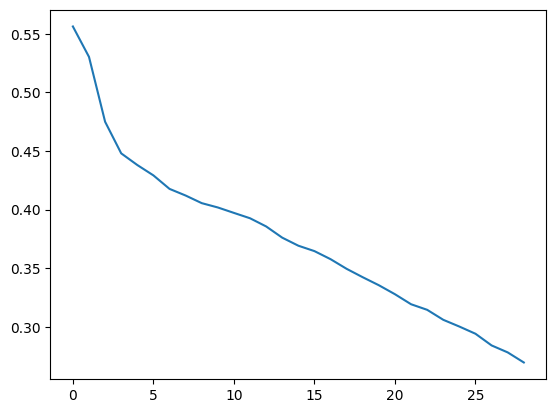

In [26]:
plt.plot(loss_list[1:])

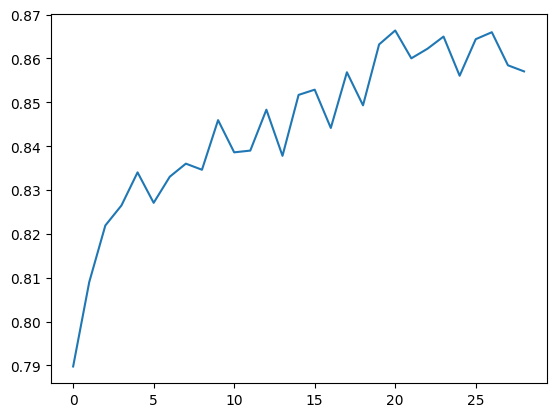

In [27]:
plt.plot(ac_list[1:])

In [34]:
torch.save(CPC_model.state_dict(),'CPC_gru')